<a href="https://colab.research.google.com/github/klordo/deep_gen_models_hws/blob/hw1/gen_hw_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Генерация на основе статистик и детекция аномалий.

In [1]:
import json
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import tqdm
import scipy.stats as stats
import collections

from torch.autograd import Variable
from itertools import product
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

## Байесовский генератор стилей

### Генерация стилей

Задача:
- Использует данные о стилях
- На основе формулы MLE и формулы Байеса о полной вероятности генерировать случайный стиль
- Так же вернуть вероятность генерации данного стиля

In [2]:
styles_data = {
    'styles': {
        'прическа': ['нет волос',
        'длинные в пучок',
        'длинные волнистые',
        'длинные прямые',
        'короткая волнистые',
        'короткая прямые',
        'короткая курчавые'],
        'цвет волос': ['черный',
        'блонд',
        'каштановый',
        'пастельный розовый',
        'рыжий',
        'серебристо серый'],
        'аксесуар': ['нет очков', 'круглые очки', 'солнцезащитные очки'],
        'одежда': ['худи',
        'комбинезон',
        'футболка с круглым вырезом',
        'футболка с V-вырезом'],
        'цвет одежды': ['черный',
        'синий',
        'серый',
        'зеленый',
        'оранжевый',
        'розовый',
        'красный',
        'белый']
  },
  'styles_count': {
        'прическа': [7, 0, 1, 23, 1, 11, 7],
        'цвет волос': [7, 6, 2, 3, 8, 24],
        'аксесуар': [11, 22, 17],
        'одежда': [7, 18, 19, 6],
        'цвет одежды': [4, 5, 6, 8, 6, 8, 7, 6]
  }
}

In [29]:
class StyleGeneration:
    def __init__(self, style_data):
        self.style_data = style_data
        self.style_probs = {}

    def fit(self):
        style_part_probs = self.get_style_part_probs(self.style_data)
        styles_variants = list(product(*self.style_data['styles'].values()))
        style_probs = {}
        for style in styles_variants:
            style_prob = 1
            for part, item in zip(self.style_data['styles'].keys(), style):
                style_prob *= style_part_probs[part][item]
            self.style_probs[style] = style_prob

    def predict(self):
        idx = random.choices(range(len(self.style_probs.keys())), list(self.style_probs.values()))[0]
        prob = list(self.style_probs.values())[idx]
        style = list(self.style_probs.keys())[idx]
        return style, prob

    @staticmethod
    def get_style_part_probs(style_data: dict):
        style_part_probs = {}
        for group_name, part_names in style_data['styles'].items():
            freqs = style_data['styles_count'][group_name]
            freqs = [(freq + 1)/(sum(freqs) + len(freqs)) for freq in freqs]
            style_part_probs[group_name] = {name: freq for freq, name in zip(freqs, part_names)}
        return style_part_probs

In [30]:
style_gen = StyleGeneration(styles_data)
style_gen.fit()

In [38]:
for i in range(3):
    style, prob = style_gen.predict()
    print(f"{i+1}) {', '.join(style)}, {prob=:.4f}")

1) короткая курчавые, рыжий, круглые очки, комбинезон, синий, prob=0.0004
2) короткая прямые, серебристо серый, круглые очки, футболка с V-вырезом, розовый, prob=0.0008
3) длинные прямые, серебристо серый, солнцезащитные очки, комбинезон, розовый, prob=0.0035


### Генерация картинок

In [9]:
AVATARS_PATH = 'avatars'

In [20]:
class AvatarGenerate:
    def __init__(self, avtar_pah: str | Path):
        self.avatar_parh = avtar_pah
        self.images = np.stack(
            [np.array(Image.open(os.path.join(avtar_pah, filename))) for filename in os.listdir(avtar_pah)]
        )
        self.h, self.w, self.c = self.images[0].shape
        self.pixel_probabilities = None

    def fit(self, mle: bool):
        if mle:
            pixels_counts = np.ones((self.h, self.w, self.c, 256))
        else:
            pixels_counts = np.zeros((self.h, self.w, self.c, 256))
        for channel in range(self.c):
            for value in range(256):
                mask = self.images[:, :, :, channel] == value
                pixels_counts[:, :, channel, value] += np.sum(mask, axis=0)
        total_counts = np.sum(pixels_counts, axis=-1, keepdims=True)

        self.pixel_probabilities = pixels_counts / total_counts

    def predict(self):
        generated_image = np.zeros(self.pixel_probabilities.shape[:-1], dtype=np.uint8)
        for h in range(self.pixel_probabilities.shape[0]):
            for w in range(self.pixel_probabilities.shape[1]):
                for c in range(self.pixel_probabilities.shape[2]):
                    generated_image[h, w, c] = np.random.choice(256, p=self.pixel_probabilities[h, w, c])
        return generated_image

In [21]:
avatar_generator = AvatarGenerate(AVATARS_PATH)

In [22]:
avatar_generator.fit(mle=False)
images_mle = [avatar_generator.predict() for _ in range(3)]

In [23]:
avatar_generator.fit(mle=True)
images_no_mle = [avatar_generator.predict() for _ in range(3)]

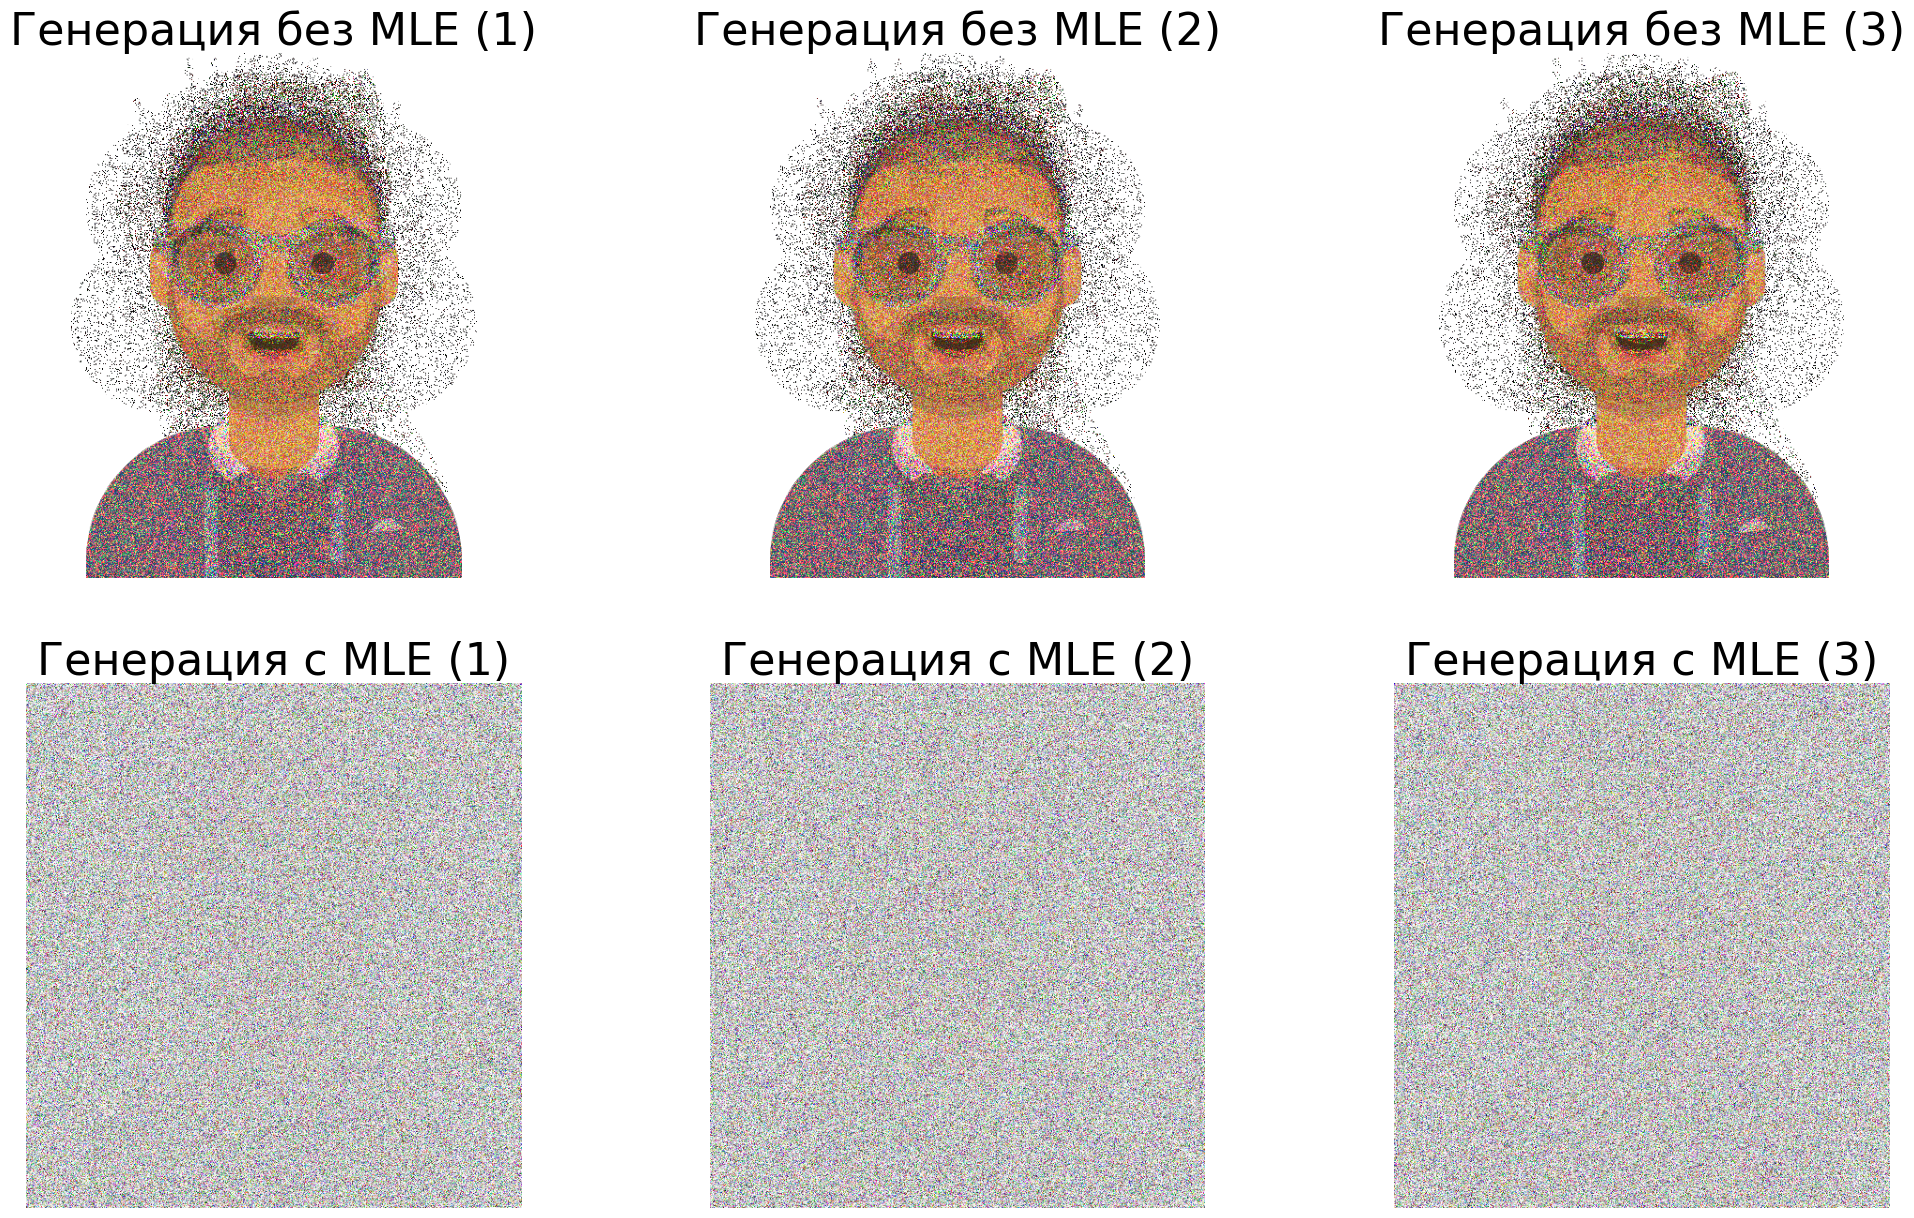

In [24]:
fig, axs = plt.subplots(2, 3, figsize=(25, 15))

for i, (img_mle, img_no_mle) in enumerate(zip(images_mle, images_no_mle)):
    axs[0, i].set_title(f'Генерация без MLE ({i+1})', fontsize=32)
    axs[0][i].imshow(img_mle)
    axs[0][i].axis('off')

    axs[1, i].set_title(f'Генерация c MLE ({i+1})', fontsize=32)
    axs[1][i].imshow(img_no_mle)
    axs[1][i].axis('off')

plt.show()

## Детекция аномалий

- Имплементировать или найти автоэкодер (можно для старта взять пример из лекции по автоэнкодерам)
- Обучаем автоэнкодер на не_проливах (dataset\train)
- Если через такой автоэнкодер прогнать изображение пролива, то MSE между входным изображением и выходным будет больше, чем если прогнать изображение без пролива. Следовательно, если определить некторое пороговое значение MSE, можно классифицировать изображение на классы пролив\не_пролив. Если MSE между входной картинкой и выходной больше фиксированного порога, то на изображении пролив.
- В качестве loss функции используем MSE (как минимум для baseline)
- Для определения порога используем изображения из dataset\proliv
- Пишем метод классификации лунок
- На изображениях из dataset\test тестируем качество. Считаем True_positive_rate и True_negative_rate.

### Класс датасета

In [ ]:
class HoleDataset(Dataset):
    def __init__(self, images_path, transform_start=None, transform_end=None):
        self.images_path = images_path
        self.transform_start = transform_start
        self.transform_end = transform_end

        self.images = [file for file in os.listdir(images_path) if file.endswith(('jpg', 'jpeg', 'png'))][300:]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_path, self.images[idx])

        image_start = Image.open(image_path).convert('RGB')

        if self.transform_end:
            image_end = self.transform_end(image_start)
        else:
            image_end = image_start

        image_start = self.transform_start(image_start)

        return image_start, image_end

### Классы модели

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [ ]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [ ]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # 128*128*3
        x1 = self.inc(x) # 128*128*64
        x2 = self.down1(x1) # 64*64*128
        x3 = self.down2(x2) # 32*32*256
        x4 = self.down3(x3) # 16*16*512
        x5 = self.down4(x4) # 8*8*512
        x = self.up1(x5, x4) # 16*16*256
        x = self.up2(x, x3) # 32*32*128
        x = self.up3(x, x2) # 64*64*64
        x = self.up4(x, x1) # 128*128*64
        logits = self.outc(x) # 128*128*3
        return logits

### Инициализация обучения

In [ ]:
n_channels = 3
n_classes = 3
h = 128
w = 128
learning_rate = 0.001
batch_size = 16
num_epochs = 10

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((h, w)),
])

dataset = HoleDataset(images_path="/content/drive/MyDrive/anomaly detection/train", transform_start=transform, transform_end=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
model = UNet(n_channels, n_classes)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

In [ ]:
loss_list = []
for epoch in range(num_epochs):
    model.train()
    for images, targets in tqdm.tqdm(dataloader):
        images = images.to(device)
        targets = targets.to(device)

        outputs = model(images)

        loss = criterion(outputs, targets)
        loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.7f}')

print("Обучение завершено.")


  0%|          | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 169/169 [01:02<00:00,  2.70it/s]


Epoch [1/10], Loss: 0.0003677


100%|██████████| 169/169 [00:30<00:00,  5.61it/s]


Epoch [2/10], Loss: 0.0003474


100%|██████████| 169/169 [00:30<00:00,  5.63it/s]


Epoch [3/10], Loss: 0.0002284


100%|██████████| 169/169 [00:30<00:00,  5.58it/s]


Epoch [4/10], Loss: 0.0001543


100%|██████████| 169/169 [00:30<00:00,  5.58it/s]


Epoch [5/10], Loss: 0.0000578


100%|██████████| 169/169 [00:30<00:00,  5.55it/s]


Epoch [6/10], Loss: 0.0001050


100%|██████████| 169/169 [00:30<00:00,  5.53it/s]


Epoch [7/10], Loss: 0.0002221


100%|██████████| 169/169 [00:30<00:00,  5.51it/s]


Epoch [8/10], Loss: 0.0000922


100%|██████████| 169/169 [00:30<00:00,  5.51it/s]


Epoch [9/10], Loss: 0.0001251


100%|██████████| 169/169 [00:30<00:00,  5.52it/s]


Epoch [10/10], Loss: 0.0001039
Обучение завершено.


### Результаты обучения

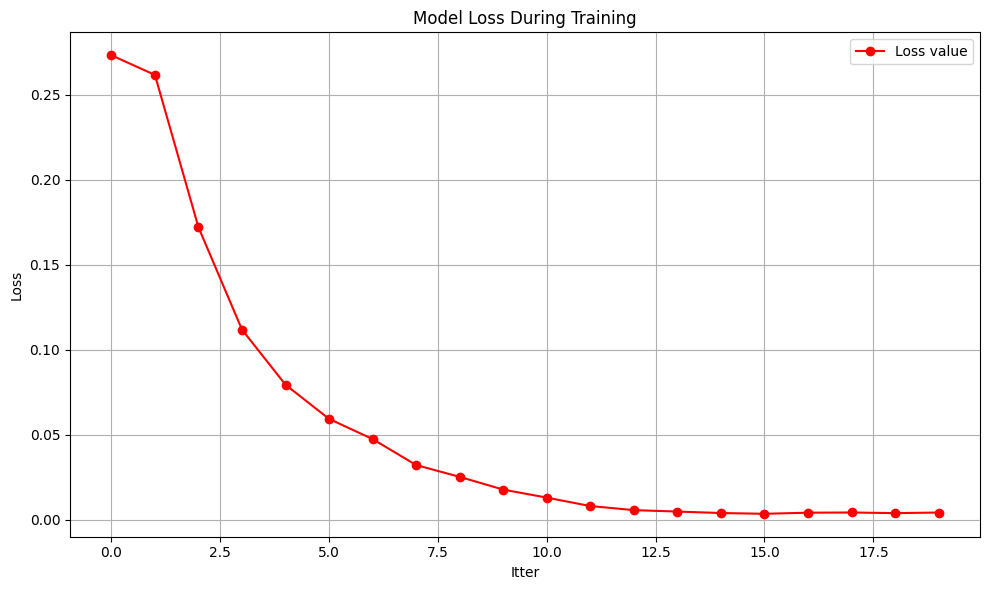

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(loss_list[:20], marker='o', color='r', label='Loss value')
plt.title('Model Loss During Training')
plt.xlabel('Itter')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
output_image = Image.open('/content/drive/MyDrive/anomaly detection/test/imgs/00572ca3-1db1-4b6f-bc8d-97e331002e52.jpg').convert('RGB')
output_image = transform(output_image)

In [ ]:
model_image = output_image.unsqueeze(0)
model_image = model(model_image.to(device))

In [ ]:
output_image = output_image.permute(1, 2, 0)
model_image = model_image.permute(0, 2, 3, 1).detach().to('cpu').numpy()[0]

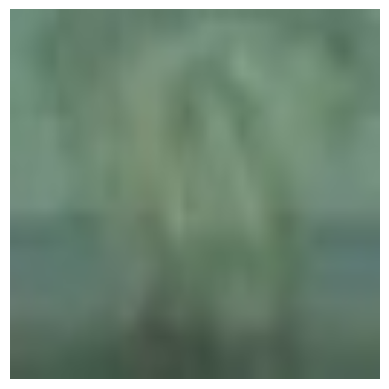

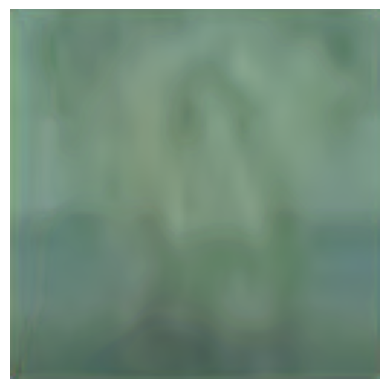

In [ ]:
plt.imshow(output_image)
plt.axis('off')
plt.show()

plt.imshow(model_image)
plt.axis('off')
plt.show()

### Определение порога

- определяем среднее mse для не_проливов
- определяем среднее mse для проливов
- перебираем значения порога в промежутке полученных средних

In [ ]:
def get_mse(images_path: str | Path, n: int) -> float:
    images = [f for f in os.listdir(images_path) if f.endswith(('jpg', 'jpeg', 'png'))]
    mses = []
    for img in tqdm.tqdm(images[:n]):
        image_path = os.path.join(images_path, img)
        image = Image.open(image_path).convert('RGB')
        image = transform(image).to(device)

        model_image = image.unsqueeze(0)
        model_image = model(model_image)

        image = image.permute(1, 2, 0)
        model_image = model_image.permute(0, 2, 3, 1).detach().to('cpu').numpy()[0]

        mses.append(((image.to('cpu') - model_image)**2).sum()/(h*w*n_channels))
    return np.array(mses)

In [ ]:
no_proliv = get_mse('/content/drive/MyDrive/anomaly detection/train', 100)

In [ ]:
proliv = get_mse('/content/drive/MyDrive/anomaly detection/proliv', 200)

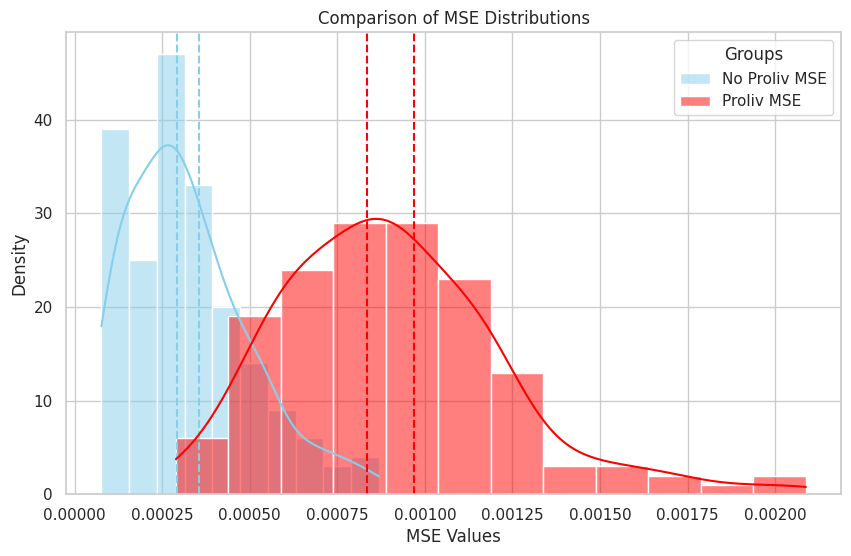

In [ ]:
# Расчет доверительных интервалов
conf_interval_no_proliv = stats.t.interval(0.99, len(no_proliv)-1, loc=np.mean(no_proliv), scale=stats.sem(no_proliv))
conf_interval_proliv = stats.t.interval(0.99, len(proliv)-1, loc=np.mean(proliv), scale=stats.sem(proliv))

# Визуализация распределений с доверительными интервалами
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# График для no_proliv_mse
sns.histplot(no_proliv, color="skyblue", label='No Proliv MSE', kde=True)
plt.axvline(conf_interval_no_proliv[0], color="skyblue", linestyle="--")
plt.axvline(conf_interval_no_proliv[1], color="skyblue", linestyle="--")

# График для proliv_mse
sns.histplot(proliv, color="red", label='Proliv MSE', kde=True)
plt.axvline(conf_interval_proliv[0], color="red", linestyle="--")
plt.axvline(conf_interval_proliv[1], color="red", linestyle="--")

plt.legend(title='Groups')
plt.title('Comparison of MSE Distributions')
plt.xlabel('MSE Values')
plt.ylabel('Density')

plt.show()

#### АБ-тест для MSE's

Определим, есть ли стат. значимые различия между выборками или нет. Если различия есть, то модель по разному восстанавливает изображения. Иначе, MSE's относятся к одной генеральной выборке, а значит и MSE для двух классов имеют примерно одинаковое значение.

Для этого воспользуемся bootstrap'ом и сделаем t-тест.

In [ ]:
def get_means(value_list: list, n: int, m: int):
    means = []
    for _ in range(m):
        items = [random.choice(value_list) for _ in range(m)]
        means.append(np.array(items).mean())
    return means

In [ ]:
group_a = get_means(no_proliv, 7000, 250)
group_b = get_means(proliv, 7000, 250)

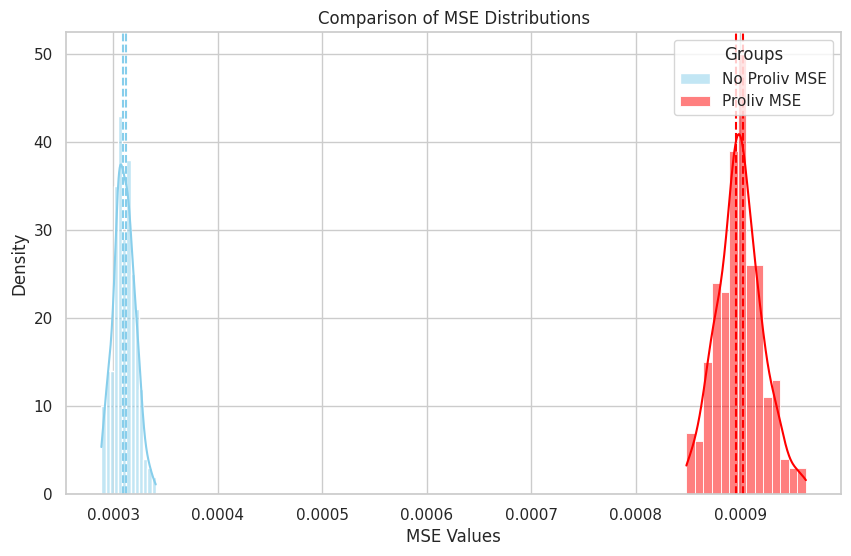

In [ ]:
# Расчет доверительных интервалов
conf_interval_no_proliv = stats.t.interval(0.99, len(group_a)-1, loc=np.mean(group_a), scale=stats.sem(group_a))
conf_interval_proliv = stats.t.interval(0.99, len(group_b)-1, loc=np.mean(group_b), scale=stats.sem(group_b))

# Визуализация распределений с доверительными интервалами
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# График для no_proliv_mse
sns.histplot(np.array(group_a), color="skyblue", label='No Proliv MSE', kde=True)
plt.axvline(conf_interval_no_proliv[0], color="skyblue", linestyle="--")
plt.axvline(conf_interval_no_proliv[1], color="skyblue", linestyle="--")

# График для proliv_mse
sns.histplot(group_b, color="red", label='Proliv MSE', kde=True)
plt.axvline(conf_interval_proliv[0], color="red", linestyle="--")
plt.axvline(conf_interval_proliv[1], color="red", linestyle="--")

plt.legend(title='Groups', loc='upper right')
plt.title('Comparison of MSE Distributions')
plt.xlabel('MSE Values')
plt.ylabel('Density')

plt.show()

In [ ]:
# equal_var - не предполагаем, что в выборках одна генеральная дисперсия
stats.ttest_ind(group_a, group_b, equal_var=False)

TtestResult(statistic=-388.4741853672812, pvalue=0.0, df=353.38513030391414)

P-value очень близок к нулю - группы различаются стат. значимо. Можнно подбирать порог.

#### Выбор порога

In [ ]:
with open('/content/drive/MyDrive/anomaly detection/test/test_annotation.txt', 'r') as f:
    annotation = [line.strip().split() for line in f.readlines()]

In [ ]:
def get_metrics(left: int, right: int, lr: int, annotation: list, images_path: str, current_label: int, n: int):
    metrics = {}
    print('Start new pointer')
    counter = 0
    for item in tqdm.tqdm(annotation):
        img, label = item
        label = int(label)

        if label != current_label:
            continue

        image_path = os.path.join(images_path, img)
        image = Image.open(image_path).convert('RGB')
        image = transform(image).to(device)

        model_image = image.unsqueeze(0)
        model_image = model(model_image)

        image = image.permute(1, 2, 0)
        model_image = model_image.permute(0, 2, 3, 1).detach().to('cpu').numpy()[0]

        mse = ((image.to('cpu') - model_image)**2).sum()/(h*w*n_channels)
        pointer = left
        while pointer < right:
            if metrics.get(pointer, None) is None:
                metrics[pointer] = {}
                metrics[pointer]['tp'] = 0
                metrics[pointer]['tn'] = 0
                metrics[pointer]['fn'] = 0
                metrics[pointer]['fp'] = 0
                metrics[pointer]['predict'] = 0
            predict = 1
            if mse < pointer:
                predict = 0
            metrics[pointer]['predict'] += predict == label
            if label and predict:
                metrics[pointer]['tp'] += 1
            elif not label and not predict:
                metrics[pointer]['tn'] += 1
            elif label and not predict:
                metrics[pointer]['fn'] += 1
            elif not label and predict:
                metrics[pointer]['fp'] += 1
            pointer += lr
        counter += 1
        if counter >= n:
            break

    return metrics

In [ ]:
metrics_proliv = get_metrics(
    no_proliv.mean(),
    proliv.mean(),
    0.00005,
    annotation,
    '/content/drive/MyDrive/anomaly detection/test/imgs',
    1,
    100)

In [ ]:
metrics_no_proliv = get_metrics(
    no_proliv.mean(),
    proliv.mean(),
    0.00005,
    annotation,
    '/content/drive/MyDrive/anomaly detection/test/imgs',
    0,
    100)

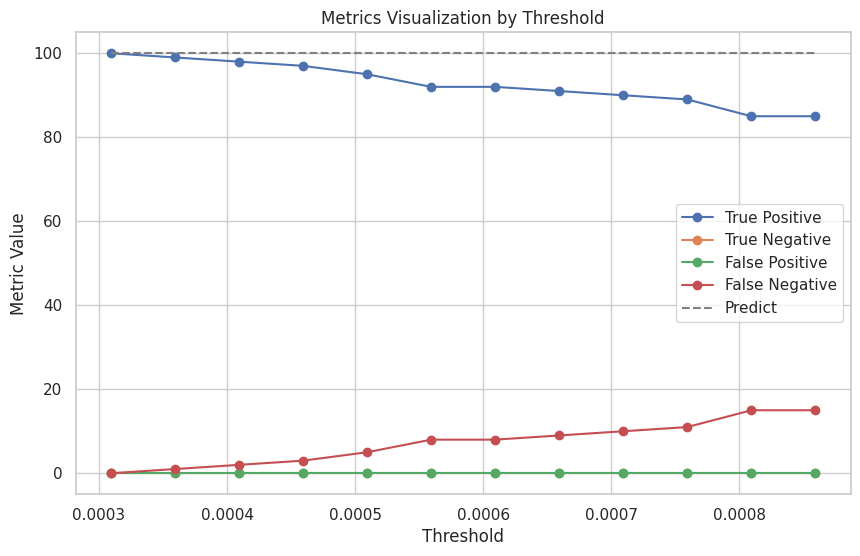

In [ ]:
thresholds_proliv = list(metrics_proliv.keys())
tps = [metrics_proliv[thr]['tp'] for thr in thresholds_proliv]
tns = [metrics_proliv[thr]['tn'] for thr in thresholds_proliv]
fps = [metrics_proliv[thr]['fp'] for thr in thresholds_proliv]
fns = [metrics_proliv[thr]['fn'] for thr in thresholds_proliv]
predicts = [metrics_proliv[thr]['predict'] for thr in thresholds_proliv]

plt.figure(figsize=(10, 6))
plt.plot(thresholds_proliv, tps, label='True Positive', marker='o')
plt.plot(thresholds_proliv, tns, label='True Negative', marker='o')
plt.plot(thresholds_proliv, fps, label='False Positive', marker='o')
plt.plot(thresholds_proliv, fns, label='False Negative', marker='o')
plt.plot(thresholds_proliv, predicts, label='Predict', linestyle='--', color='grey')

plt.title('Metrics Visualization by Threshold')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

При пороге ~0.0008:
- ~82% проливов обнаружено и ~18% проливов обозначены не_проливами
- fp и tn в нуле, т.к. замерялся только класс проливов

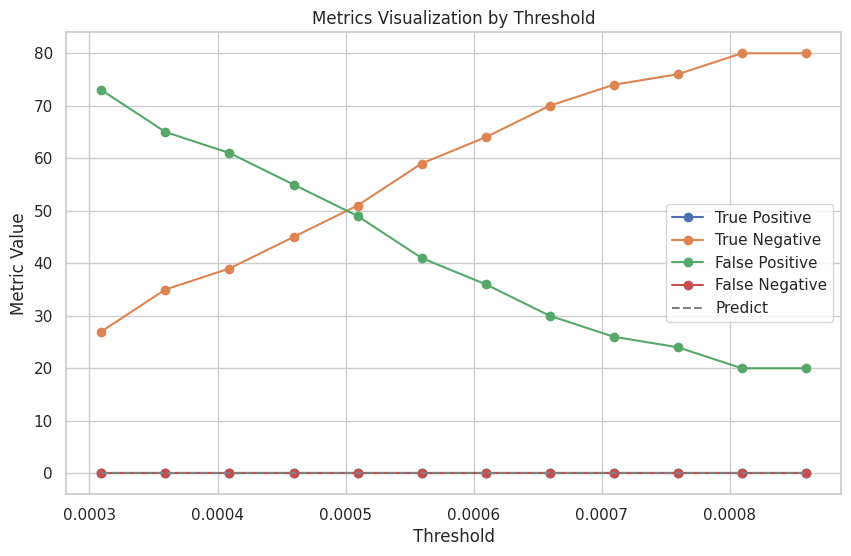

In [ ]:
thresholds_no_proliv = list(metrics_no_proliv.keys())
tps = [metrics_no_proliv[thr]['tp'] for thr in thresholds_no_proliv]
tns = [metrics_no_proliv[thr]['tn'] for thr in thresholds_no_proliv]
fps = [metrics_no_proliv[thr]['fp'] for thr in thresholds_no_proliv]
fns = [metrics_no_proliv[thr]['fn'] for thr in thresholds_no_proliv]
predicts = [metrics_no_proliv[thr]['predict'] for thr in thresholds_no_proliv]

plt.figure(figsize=(10, 6))
plt.plot(thresholds_no_proliv, tps, label='True Positive', marker='o')
plt.plot(thresholds_no_proliv, tns, label='True Negative', marker='o')
plt.plot(thresholds_no_proliv, fps, label='False Positive', marker='o')
plt.plot(thresholds_no_proliv, fns, label='False Negative', marker='o')
plt.plot(thresholds_no_proliv, predicts, label='Predict', linestyle='--', color='grey')

plt.title('Metrics Visualization by Threshold')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

При пороге ~0.0008:
- ~82% не\_проливов обнаружено и ~18% не\_проливов обозначены проливами
- tp и fn в нуле, т.к. замерялся только класс проливов

In [ ]:
predicts_proliv = [metrics_proliv[thr]['predict'] for thr in thresholds_proliv]
predicts_no_proliv = [metrics_no_proliv[thr]['predict'] for thr in thresholds_no_proliv]
precision =  [x+y for x, y in zip(predicts_proliv, predicts_no_proliv)]

In [ ]:
thresholds_proliv = list(metrics_proliv.keys())
thresholds_no_proliv = list(metrics_no_proliv.keys())
tps = [metrics_proliv[thr]['tp'] for thr in thresholds_proliv]
fns = [metrics_proliv[thr]['fn'] for thr in thresholds_proliv]
tns = [metrics_no_proliv[thr]['tn'] for thr in thresholds_no_proliv]
fps = [metrics_no_proliv[thr]['fp'] for thr in thresholds_no_proliv]

plt.figure(figsize=(10, 6))
plt.plot(thresholds_proliv, tps, label='True Positive', marker='o')
plt.plot(thresholds_proliv, fns, label='False Negative', marker='o')
plt.plot(thresholds_no_proliv, tns, label='True Negative', marker='o')
plt.plot(thresholds_no_proliv, fps, label='False Positive', marker='o')

plt.plot(thresholds_proliv, precision, label='Precision', linestyle='--', color='grey')

plt.title('Metrics Visualization by Threshold')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

При пороге ~0.0008:
- ~82% проливов обнаружено и ~18% проливов обозначены не_проливами
- fp и tn в нуле, т.к. замерялся только класс проливов
- ~82% не_проливов обнаружено и ~18% не_проливов обозначены проливами
- tp и fn в нуле, т.к. замерялся только класс проливов